## Train DNN for MNIST dataset, with and without BN

Following cell includes implementation of batch norm mathematics as per **Algorithm 1** in the paper for both CNN and linear layer neurons based on input size and for CNN, BN is applied to each feature map/ channel.

It includes training the model on mnist dataset with a simple 3 linear layer architecture and comparison of outputs for both with and without batch normalization.

**Graph 1**: Difference in validation accuracy achieved with and without BN against the number of training steps.

**Graph 2**: 15th, 50th and 85th percentile of data in the batch and it's change over the entire training steps for a single specific neuron for observation of internal covarite shift without batch normalization

**Graph 3**: 15th, 50th and 85th percentile of data in the batch and it's change over the entire training steps for a single specific neuron for observation of stability when using batch normalization


### Computing output values for each curve

Loaders ready


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


step 0: acc_base=0.0980 acc_bn=0.0958
step 2500: acc_base=0.1135 acc_bn=0.8996
step 5000: acc_base=0.1135 acc_bn=0.9166
step 7500: acc_base=0.2354 acc_bn=0.9265
step 10000: acc_base=0.4166 acc_bn=0.9343
step 12500: acc_base=0.5547 acc_bn=0.9374
step 15000: acc_base=0.6762 acc_bn=0.9473
step 17500: acc_base=0.7460 acc_bn=0.9518
step 20000: acc_base=0.7934 acc_bn=0.9556
step 22500: acc_base=0.8270 acc_bn=0.9565
step 25000: acc_base=0.8438 acc_bn=0.9586
step 27500: acc_base=0.8584 acc_bn=0.9586
step 30000: acc_base=0.8682 acc_bn=0.9657
step 32500: acc_base=0.8745 acc_bn=0.9648
step 35000: acc_base=0.8811 acc_bn=0.9654
step 37500: acc_base=0.8866 acc_bn=0.9652
step 40000: acc_base=0.8901 acc_bn=0.9694
step 42500: acc_base=0.8958 acc_bn=0.9680
step 45000: acc_base=0.8999 acc_bn=0.9695
step 47500: acc_base=0.9032 acc_bn=0.9695
step 49999: acc_base=0.9090 acc_bn=0.9718
Training complete. Time: 1846.0s
size of p15 50000


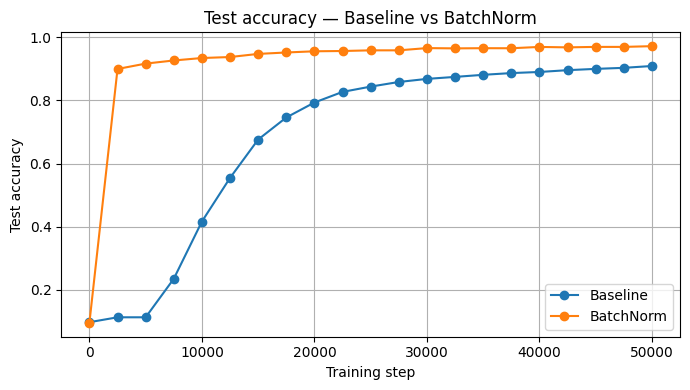

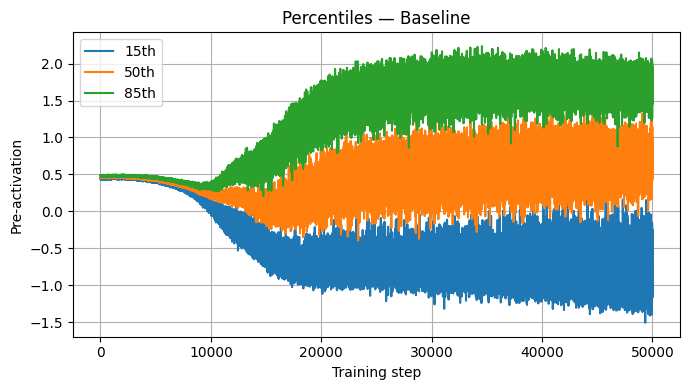

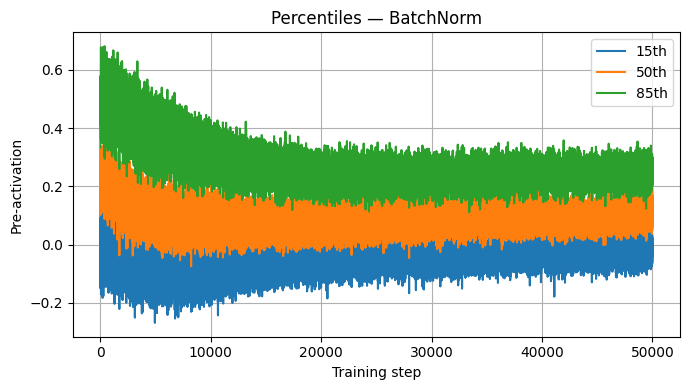

In [ ]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os

# defining constants
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 60
STEPS = 50000
SNAPSHOT_EVERY = 2500
LR = 0.01
HIDDEN_UNITS = 100 # number of hidden units
NEURON_INDEX = 5 # the neuron for which we are measuring the covraite shift
OUTPUT_DIR = 'bn_results_21'
os.makedirs(OUTPUT_DIR, exist_ok=True)
CHECKPOINT_FILE = os.path.join(OUTPUT_DIR, 'checkpoint_last.pt')

# custom batch norm class
class BatchNorm(nn.Module):
    # this will take as input the previous neuron's output and apply normalization before giving non-linearity
    def __init__(self,num_features,eps=1e-5,momentum=0.1):
        super().__init__()
        # parameters added for each feature i.e. each previous later neuron
        # setting gamma to be 0 and beta to be 1 i.e. identity transformation of input
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta  = nn.Parameter(torch.zeros(num_features))

        # storing running mean and variance to be used for inference time
        self.register_buffer("running_mean", torch.zeros(num_features))
        self.register_buffer("running_var", torch.ones(num_features))

        self.eps = eps
        self.momentum = momentum

    # defining forward layer
    def forward(self, x):
        # If it has batch_size, feature, height and width then it's convolutional layer
        # Case 2: If it has just batch size and neuron's (features) then fully connected
        if x.dim() == 4:
            # training for each feature map in CNN
            dims = (0, 2, 3)
            shape = (1, x.size(1), 1, 1)
        else:
            # training for each feature in output
            dims = (0,)
            shape = (1, x.size(1))

        # during training mode compute statistics and in testing mode use train time running averages
        if self.training:
            # taking mean over feature/feature map
            batch_mean = x.mean(dim=dims)
            batch_var  = x.var(dim=dims, unbiased=False) # use population variance forumla

            # normalize
            x_hat = (x - batch_mean.view(shape)) / torch.sqrt(batch_var.view(shape) + self.eps)

            # Update running statistics
            self.running_mean = (
                self.momentum * self.running_mean
                + (1 - self.momentum) * batch_mean.detach() # detach to make sure no use of gradients for these values
            )
            self.running_var = (
                self.momentum * self.running_var
                + (1 - self.momentum) * batch_var.detach()
            )

        else:
            # during inference using the running averages
            x_hat = (x - self.running_mean.view(shape)) / torch.sqrt(self.running_var.view(shape) + self.eps)

        # Scale and shift the output to ensure model's learning is not restricted
        out = self.gamma.view(shape) * x_hat + self.beta.view(shape)
        return out


# defining custom DNN for mnist training
class MNIST_NN(nn.Module):
    def __init__(self, use_bn=True, hidden=HIDDEN_UNITS):
        super().__init__()
        self.fc1 = nn.Linear(28*28, hidden)
        self.bn1 = BatchNorm(hidden) if use_bn else nn.Identity()
        self.fc2 = nn.Linear(hidden, hidden)
        self.bn2 = BatchNorm(hidden) if use_bn else nn.Identity()
        self.fc3 = nn.Linear(hidden, hidden)
        self.bn3 = BatchNorm(hidden) if use_bn else nn.Identity()
        self.fc_out = nn.Linear(hidden, 10)
        self.use_bn = use_bn
        self.last_preact = None
        # initialize small gaussian weights as mentioned in paper
        self._init_weights_lecun()

    # as proposed in paper, initially weights with small random gaussian values
    def _init_weights_lecun(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.uniform_(m.weight, -np.sqrt(3/m.in_features), np.sqrt(3/m.in_features))
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, BatchNorm):
                nn.init.constant_(m.running_mean, 0.0)
                nn.init.constant_(m.running_var, 1.0)

    # forward function for model
    def forward(self, x, return_preact=False):
        if x.dim() == 4:
            x = x.view(-1, 28*28)

        if self.use_bn:
            u1 = self.fc1(x); x = torch.sigmoid(self.bn1(u1))
            u2 = self.fc2(x); x = torch.sigmoid(self.bn2(u2))
            u3 = self.fc3(x)
            if return_preact: self.last_preact = u3.detach().cpu() # used in order to get the last layer's value before activation
            x = torch.sigmoid(self.bn3(u3))
        else:
            u1 = self.fc1(x); x = torch.sigmoid(u1)
            u2 = self.fc2(x); x = torch.sigmoid(u2)
            u3 = self.fc3(x)
            if return_preact: self.last_preact = u3.detach().cpu() # used in order to get the last layer's value before activation
            x = torch.sigmoid(u3)

        return self.fc_out(x)


def get_loaders(batch_size=BATCH_SIZE):
    """Data loaders based on batch size"""
    transform = transforms.Compose([
        # converting image to tensor
        transforms.ToTensor()
    ])
    trainset = datasets.MNIST(root='.', train=True, download=True, transform=transform)
    testset  = datasets.MNIST(root='.', train=False, download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    testloader  = DataLoader(testset, batch_size=1000, shuffle=False, num_workers=0, pin_memory=True) # batch size for testing is set to 1000
    return trainloader, testloader

@torch.no_grad()
def evaluate(model, testloader, device=DEVICE):
    model.eval()
    correct = 0
    total = 0
    for x, y in testloader:
        x, y = x.to(device), y.to(device)
        pred = model(x).argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    model.train()
    return correct / total

def compute_percentiles_from_preact(model, neuron_index=NEURON_INDEX):
    if model.last_preact is None:
        return None
    vals = model.last_preact[:, neuron_index].numpy()
    return np.quantile(vals, 0.15), np.quantile(vals, 0.5), np.quantile(vals, 0.85) # computing quantiles for the neuron

# lists to store results
acc_history_base = []
acc_history_bn = []
steps_record = []

p15_base = []; p50_base = []; p85_base = []
p15_bn = []; p50_bn = []; p85_bn = []

# parameters for training
steps=STEPS
batch_size=BATCH_SIZE
snapshot_every=SNAPSHOT_EVERY
lr=LR
neuron_index=NEURON_INDEX
device=DEVICE

# loading dataset
trainloader, testloader = get_loaders(batch_size)

# initializing 2 classes one with and another without BN
model_base = MNIST_NN(use_bn=False).to(device)
model_bn   = MNIST_NN(use_bn=True).to(device)

# 2 optimizer for each model
opt_base = torch.optim.SGD(model_base.parameters(), lr=lr)
opt_bn   = torch.optim.SGD(model_bn.parameters(), lr=lr)

it_train_base = iter(trainloader)
it_train_bn   = iter(trainloader)

# measure start time
start_time = time.time()

for step in range(steps):
    # iterator through data
    try: xb_base, yb_base = next(it_train_base)
    except StopIteration: it_train_base = iter(trainloader); xb_base, yb_base = next(it_train_base)
    try: xb_bn, yb_bn = next(it_train_bn)
    except StopIteration: it_train_bn = iter(trainloader); xb_bn, yb_bn = next(it_train_bn)

    # ensuring that both the data is on same device
    xb_base, yb_base = xb_base.to(device), yb_base.to(device)
    xb_bn, yb_bn = xb_bn.to(device), yb_bn.to(device)

    # Train baseline
    out = model_base(xb_base)
    loss = F.cross_entropy(out, yb_base)
    opt_base.zero_grad()
    loss.backward()
    opt_base.step()

    # Train BN
    out2 = model_bn(xb_bn)
    loss2 = F.cross_entropy(out2, yb_bn)
    opt_bn.zero_grad()
    loss2.backward()
    opt_bn.step()

    # Getting output distribution
    sample_x, _ = next(iter(trainloader))
    # switching to eval model to use running stats in batch norm
    model_base.eval(); _ = model_base(sample_x.to(device), return_preact=True); model_base.train()
    ps = compute_percentiles_from_preact(model_base, neuron_index)
    p15_base.append(ps[0]); p50_base.append(ps[1]); p85_base.append(ps[2])

    model_bn.eval(); _ = model_bn(sample_x.to(device), return_preact=True); model_bn.train()
    ps2 = compute_percentiles_from_preact(model_bn, neuron_index)
    p15_bn.append(ps2[0]); p50_bn.append(ps2[1]); p85_bn.append(ps2[2])


    # Evaluate on batch step
    if (step % snapshot_every == 0) or (step == steps-1):
        acc_b = evaluate(model_base, testloader, device)
        acc_n = evaluate(model_bn, testloader, device)
        acc_history_base.append(acc_b); acc_history_bn.append(acc_n)
        steps_record.append(step)
        print(f"step {step}: acc_base={acc_b:.4f} acc_bn={acc_n:.4f}")

        # Save checkpoint
        checkpoint = {
            'step': step,
            'model_base_state': model_base.state_dict(),
            'model_bn_state': model_bn.state_dict(),
            'opt_base_state': opt_base.state_dict(),
            'opt_bn_state': opt_bn.state_dict(),
            'p15_base': p15_base, 'p50_base': p50_base, 'p85_base': p85_base,
            'p15_bn': p15_bn, 'p50_bn': p50_bn, 'p85_bn': p85_bn,
            'acc_history_base': acc_history_base, 'acc_history_bn': acc_history_bn,
            'steps_record': steps_record
        }
        torch.save(checkpoint, CHECKPOINT_FILE)

# getting total duration
total_time = time.time() - start_time
print(f"Training complete. Time: {total_time:.1f}s")

print("size of p15", len(p15_base))

results = {
    'steps': steps_record,
    'acc_base': acc_history_base,
    'acc_bn': acc_history_bn,
    'p15_base': p15_base, 'p50_base': p50_base, 'p85_base': p85_base,
    'p15_bn': p15_bn, 'p50_bn': p50_bn, 'p85_bn': p85_bn,
    'neuron_index': neuron_index
}

# Plotting accuracy
plt.figure(figsize=(7,4))
plt.plot(results['steps'], results['acc_base'], marker='o')
plt.plot(results['steps'], results['acc_bn'], marker='o')
plt.xlabel('Training step'); plt.ylabel('Test accuracy')
plt.title('Test accuracy — Baseline vs BatchNorm')
plt.legend(['Baseline', 'BatchNorm']); plt.grid(True); plt.tight_layout(); plt.show()

x_full = range(len(results['p15_base']))

plt.figure(figsize=(7,4))
plt.plot(x_full, results['p15_base'], label='15th')
plt.plot(x_full, results['p50_base'], label='50th')
plt.plot(x_full, results['p85_base'], label='85th')
plt.xlabel('Training step')
plt.ylabel('Pre-activation')
plt.title('Percentiles — Baseline')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(x_full, results['p15_bn'], label='15th')
plt.plot(x_full, results['p50_bn'], label='50th')
plt.plot(x_full, results['p85_bn'], label='85th')
plt.xlabel('Training step')
plt.ylabel('Pre-activation')
plt.title('Percentiles — BatchNorm')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



#### Save models

In [ ]:
# saving models
torch.save(model_bn.state_dict(), os.path.join(OUTPUT_DIR, 'model_bn_final.pt'))
torch.save(model_base.state_dict(), os.path.join(OUTPUT_DIR, 'model_base_final.pt'))
print(f"Final BN model saved to {os.path.join(OUTPUT_DIR, 'model_bn_final.pt')}")
print(f"Final Baseline model saved to {os.path.join(OUTPUT_DIR, 'model_base_final.pt')}")

Final BN model saved to bn_results_21/model_bn_final.pt
Final Baseline model saved to bn_results_21/model_base_final.pt


#### Present values for only every 2000 sample as this distribution is too cluttered

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sampled_three(p15, p50, p85, sample_every=100, title="Smoothed Pre-activation Curves"):
    """
    Plots 15th, 50th, 85th percentile curves together after sampling.
    p15, p50, p85 = full-length arrays (50k long)
    sample_every = sample every N points
    """

    p15 = np.array(p15)[::sample_every]
    p50 = np.array(p50)[::sample_every]
    p85 = np.array(p85)[::sample_every]

    steps = np.arange(len(p15)) * sample_every

    plt.figure(figsize=(8,5))
    plt.plot(steps, p15, label="15th percentile")
    plt.plot(steps, p50, label="50th percentile")
    plt.plot(steps, p85, label="85th percentile")
    plt.xlabel("Training step")
    plt.ylabel("Pre-activation")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig(title)


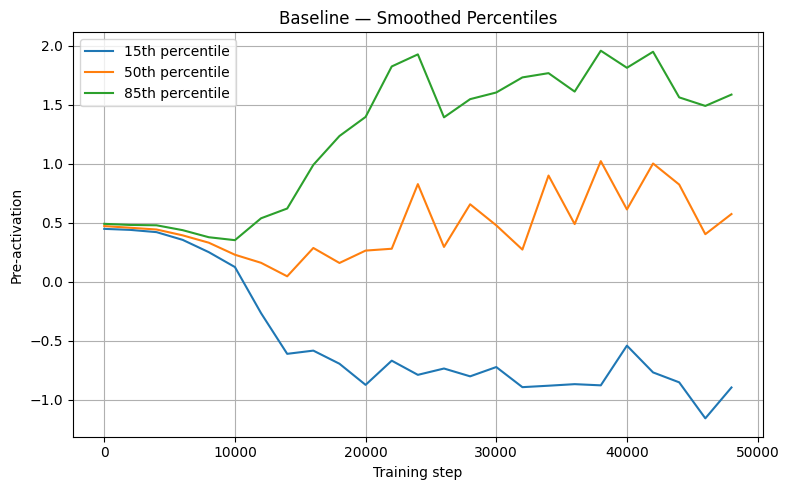

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_sampled_three(
    results['p15_base'],
    results['p50_base'],
    results['p85_base'],
    sample_every=2000,
    title="Baseline — Smoothed Percentiles"
)


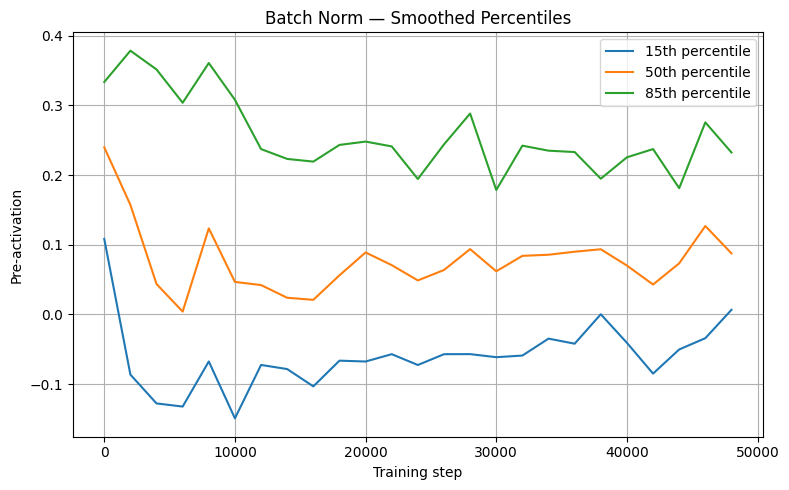

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_sampled_three(
    results['p15_bn'],
    results['p50_bn'],
    results['p85_bn'],
    sample_every=2000,
    title="Batch Norm — Smoothed Percentiles"
)
